In [25]:
import numpy as np

from qiskit.test.mock import FakeRome
from qiskit import transpile, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.algorithms.phase_estimators import PhaseEstimation
from qiskit.providers.aer import AerProvider
from qiskit.tools.visualization import plot_histogram
from qiskit.utils import QuantumInstance

In [26]:
fake_rome = FakeRome()

depth =  3


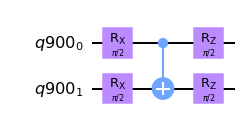

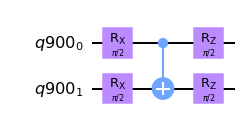

In [27]:
num_unitary_qubits = 2
unitary_qubit = QuantumRegister(num_unitary_qubits)
unitary_circuit = QuantumCircuit(unitary_qubit)
for i in range(num_unitary_qubits):
    unitary_circuit.rx(0.5*np.pi, i)
for i in range(num_unitary_qubits - 1):
    unitary_circuit.cx(i, i+1)
for i in range(num_unitary_qubits):
    unitary_circuit.rz(0.5*np.pi, i)
print("depth = ", unitary_circuit.depth())
unitary_circuit.draw('mpl')

In [28]:
unitary_simulator = AerProvider().get_backend('unitary_simulator')
job_unitary = unitary_simulator.run(unitary_circuit)
mat = job_unitary.result().get_unitary()

In [29]:
eigval, eigvec = np.linalg.eig(mat)
assert all(np.isclose(np.abs(eigval), 1.0))
eigph = np.angle(eigval)
for i, p in enumerate(eigph):
    if p < 0:
        eigph[i] = 2*np.pi + p
print("eig phase = ", eigph)
for i, v in enumerate(eigvec):
    print(f"eigvec {i} = {v/np.linalg.norm(v, ord=2)}")

eig phase =  [3.92699082e+00 4.71238898e+00 2.08767645e-16 7.85398163e-01]
eigvec 0 = [ 6.53281482e-01+0.00000000e+00j -2.51781455e-16-5.00000000e-01j
  5.00000000e-01+0.00000000e+00j -2.70598050e-01+7.24755364e-17j]
eigvec 1 = [ 6.53281482e-01+1.37661810e-16j  5.07774975e-17+5.00000000e-01j
 -5.00000000e-01-1.85423854e-16j -2.70598050e-01+1.77524568e-17j]
eigvec 2 = [ 2.70598050e-01-1.74311524e-16j  5.00000000e-01+4.52157710e-17j
 -5.44450361e-16-5.00000000e-01j  6.53281482e-01+0.00000000e+00j]
eigvec 3 = [-2.70598050e-01-5.87812805e-17j  5.00000000e-01+0.00000000e+00j
  1.90001103e-16-5.00000000e-01j -6.53281482e-01+3.16130003e-16j]


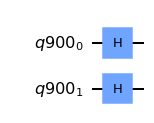

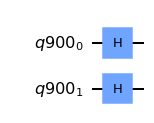

In [30]:
state_prep = QuantumCircuit(unitary_qubit)
state_prep.h(unitary_qubit)
state_prep.draw('mpl')

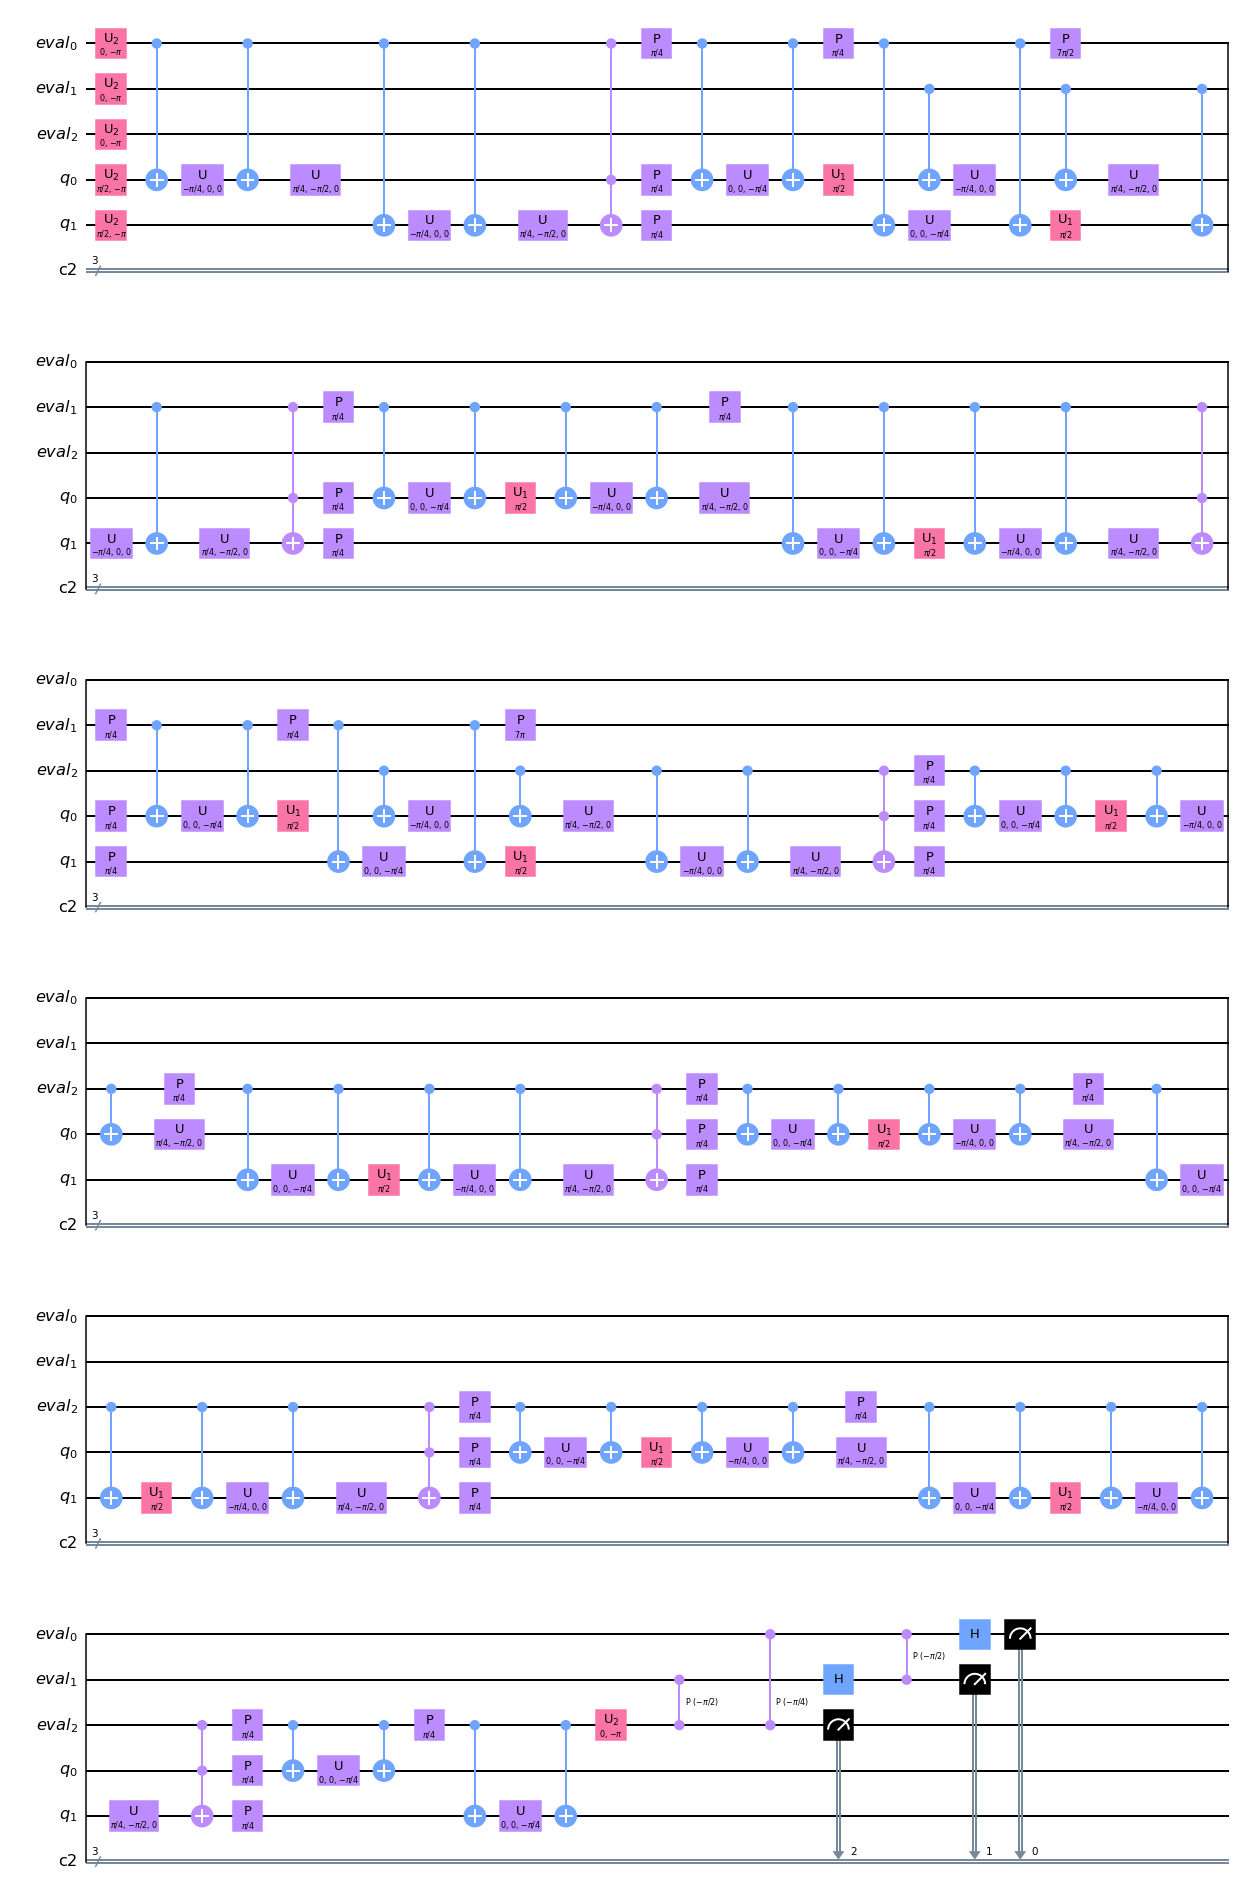

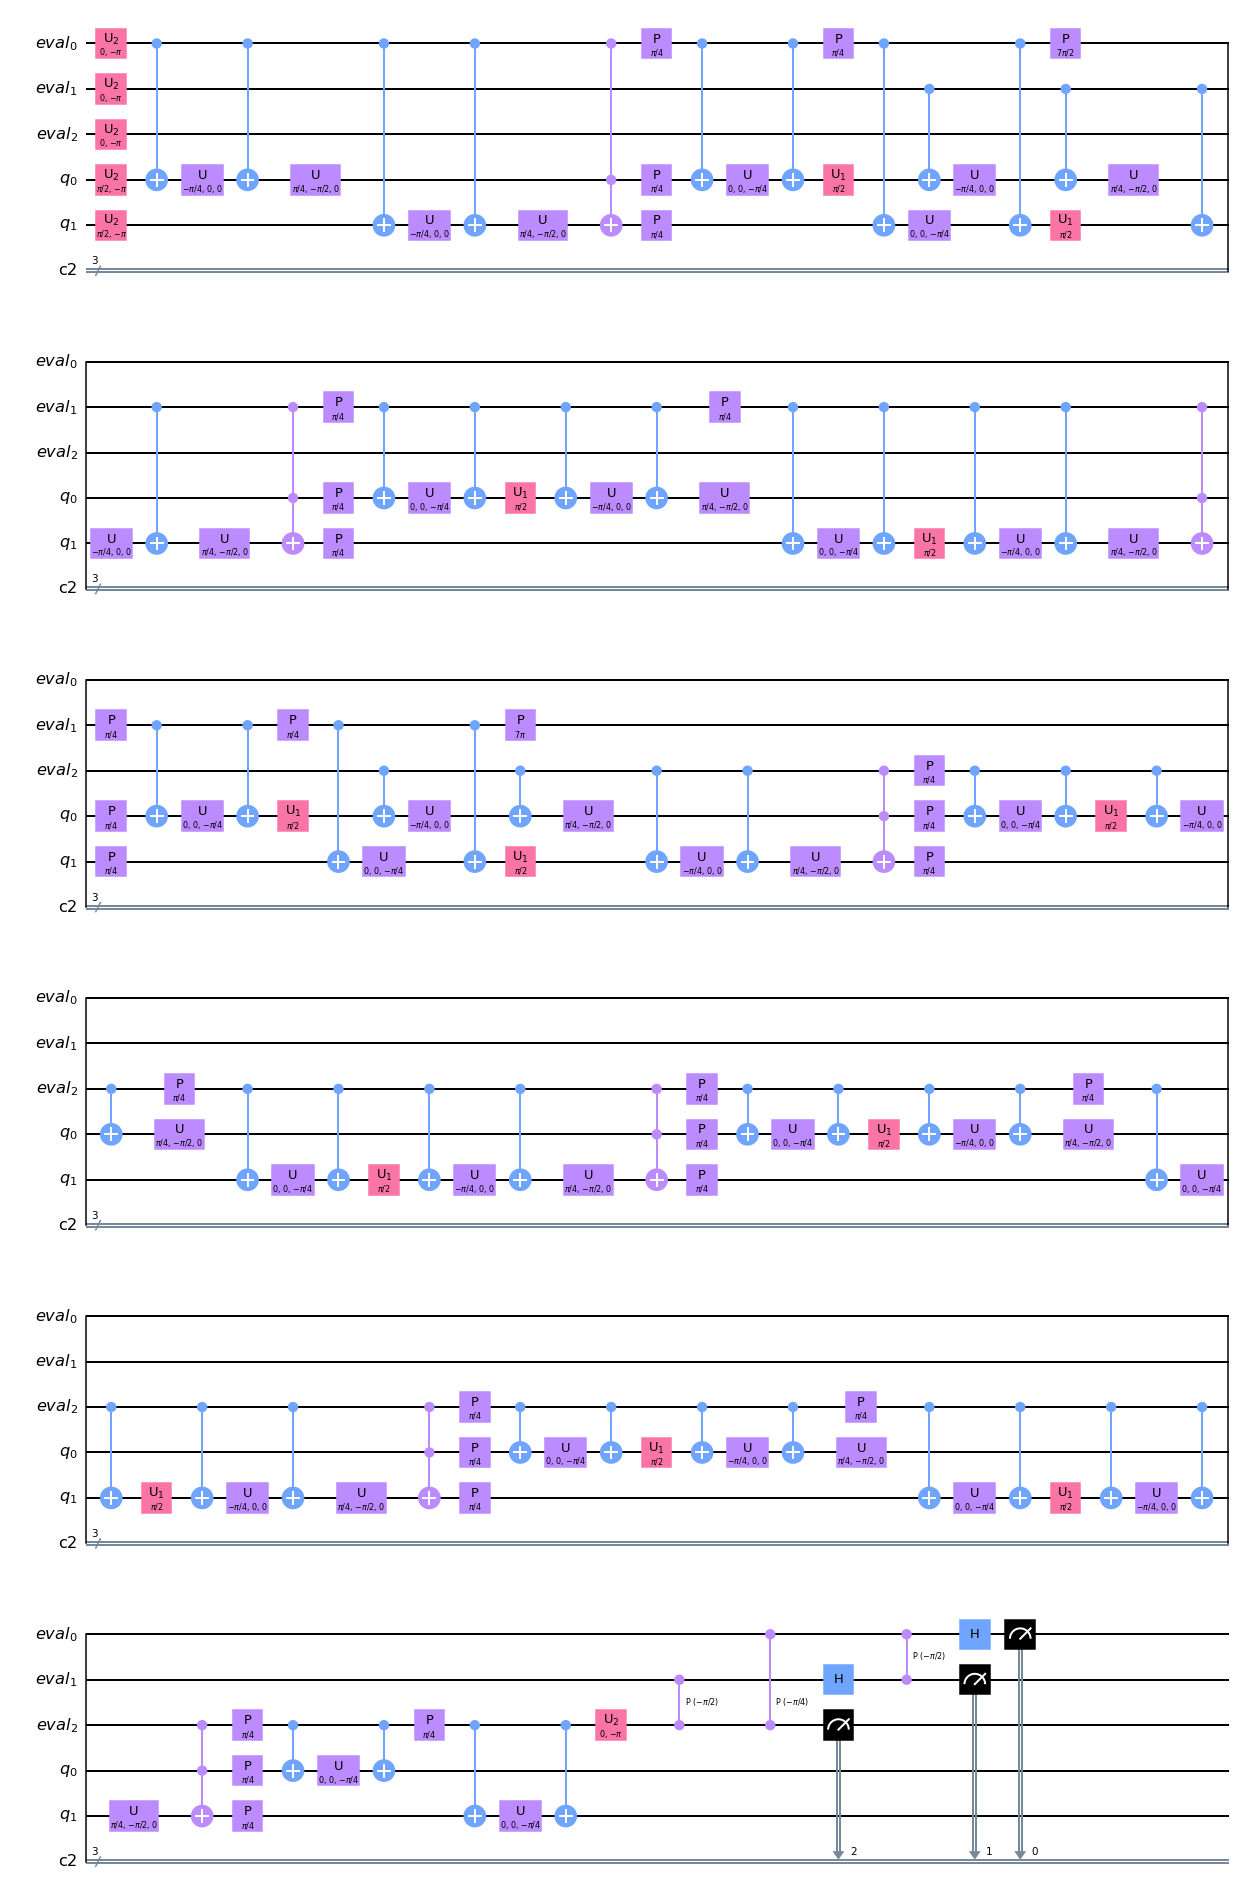

In [31]:
num_evaluation_qubits = 3
qasm_backend = AerProvider().get_backend("qasm_simulator")
qpe = PhaseEstimation(num_evaluation_qubits=num_evaluation_qubits,
                      quantum_instance=QuantumInstance(backend=qasm_backend,shots=4096))
ckt = qpe.construct_circuit(unitary_circuit, state_preparation=state_prep)
ckt = transpile(ckt, backend=qasm_backend)
eval_qubits = ckt.qregs[0]
creg = ClassicalRegister(len(eval_qubits))
ckt.add_register(creg)
ckt.measure(eval_qubits, creg)
ckt.draw('mpl')


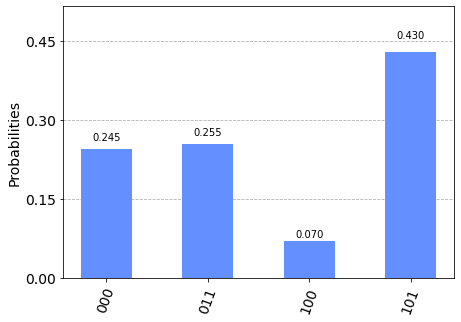

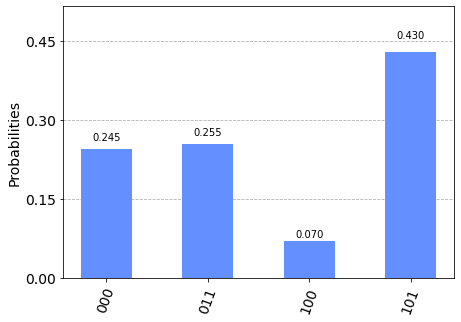

In [32]:
job_qasm = qasm_backend.run(ckt, shots=4096)
counts = job_qasm.result().get_counts()
plot_histogram(counts)

In [33]:
res = qpe.estimate(unitary_circuit, state_prep)

In [34]:
phase_list = sorted(res.phases.keys(), key=lambda x: res.phases[x], reverse=True)
for p in phase_list:
    bin_p = int(p, 2) / 2**num_evaluation_qubits
    print(p, 2*bin_p*np.pi)

101 3.9269908169872414
000 0.0
110 4.71238898038469
001 0.7853981633974483


In [35]:
ckt_lv0 = transpile(ckt, backend=fake_rome, optimization_level=0)
ckt_lv1 = transpile(ckt, backend=fake_rome, optimization_level=1)
ckt_lv2 = transpile(ckt, backend=fake_rome, optimization_level=2)
ckt_lv3 = transpile(ckt, backend=fake_rome, optimization_level=3)

In [36]:
for i, ckt_opt in enumerate([ckt_lv0, ckt_lv1, ckt_lv2, ckt_lv3]):
    cnot_count = ckt_opt.count_ops()['cx'] if 'cx' in ckt_opt.count_ops() else 0
    print(f"opt_level={i}, depth={ckt_opt.depth()}, cnot_count={cnot_count}")

opt_level=0, depth=506, cnot_count=191
opt_level=1, depth=324, cnot_count=196
opt_level=2, depth=336, cnot_count=198
opt_level=3, depth=293, cnot_count=137
